## Viscosity Model

**`DOil_Visc_Model`**

Dead oil viscosity model. There 3 options:
T in degree F, match a and b.
1. $\mu = ae^{-bT}$
    - $ln(\mu) = -bT + ln(a)$
2. $\mu = 10^{10^{(alog10(\frac{T_{ref}+460}{T+460}) + log10(log10(b)))}}$
    - a is a constant conefficient to fit with lab data
    - b is the reference viscosity at T_ref
3. $\mu = aT^{-b}$ 

> Tref = 122
- For NE a = 4.708, b = 1500. 
- For South a = 3.157, b = 575
- Increasing a will make oil less mobile when T < T_ref, but more mobile when T > T_ref
- Increasing b will make oil less mobile

In [1]:
import matplotlib.pyplot as plt
import numpy as np

In [84]:
def vis_1(a, b, t):
    return a * np.exp(-b * T)
def vis_2(a, b, t, Tref = 122):
    tmp = a * np.log10((Tref+460)/(T+460)) + np.log10(np.log10(b))
    return 10**10**tmp

### Analysis on a and b

Text(0.5,1,'analysis on b(reference visco)')

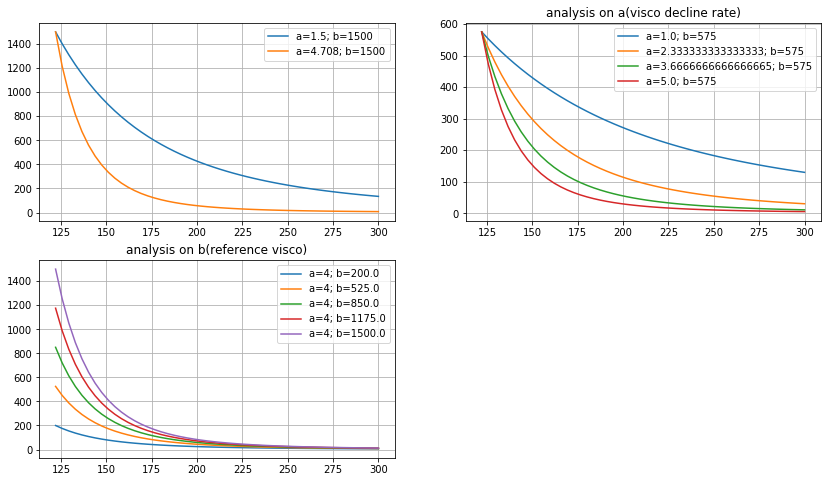

In [289]:
# Analysis on a and b
fig = plt.figure(figsize=(14,8))
axs = [fig.add_subplot(221), fig.add_subplot(222), fig.add_subplot(223)]
T = np.linspace(122,300)
a = [1.5, 4.708]
b = [1500, 1500]
T_ref = [122, 122]
for i in range(len(a)):
    axs[0].plot(T, vis_2(a[i], b[i], T, T_ref[i]), label= f'a={a[i]}; b={b[i]}')
axs[0].legend()
axs[0].grid()


# analysis on a (decline rate) @ muo_ref=575
a = np.linspace(1,5, 4)
b = [575] * len(a)
for i in range(len(a)):
    axs[1].plot(T, vis_2(a[i], b[i], T), label= f'a={a[i]}; b={b[i]}')
axs[1].legend()
axs[1].grid()
axs[1].set_title(f'analysis on a(visco decline rate)')

# analysis on b(muo_ref=575) @ a=4
plt.figure()
b = np.linspace(200, 1500, 5)
a = [4] * len(b)
for i in range(len(a)):
    axs[2].plot(T, vis_2(a[i], b[i], T), label= f'a={a[i]}; b={b[i]}')
axs[2].legend()
axs[2].grid()
axs[2].set_title(f'analysis on b(reference visco)')

## Relative Permeability
**Baker's Three-Phase Linear Interpolation Model**

Assumptions

- Sgr = 0

Water Relperm

For Sw <= 1-Sor
$K_{rw}  = (\frac{S_w - S_{wr}}{1 - S_{wr} - S_{or}})^{N_w}  K_{rw,end}$

For Sw > 1-Sor, linear intropolate to real end point
$K_{rw}  = K_{rw,end} + \frac{1-K_{rw,end}}{S_{or}}  (Sw - 1 + S_{or})$


Gas Relperm

For Sg <= 1-Sor
$K_{rg}  = (\frac{S_g}{1 - S_{or}})^{N_g}  K_{rg,end}$


Oil Relperm

$K_{row}  = (\frac{S_o - S_{or}}{1 - S_{wr} - S_{or}})^{N_{ow}}  K_{row,end}$

$K_{rog}  = (\frac{S_o - S_{or}}{1 - S_{wr} - S_{or}})^{N_{og}}  K_{rog,end}$

$K_{ro} =  \frac{S_w - S_{wr}}{S_w + S_g - S_{wr}}K_{row} + \frac{S_g}{S_w + S_g - S_{wr}}K_{rog}$

In [295]:
# relperm params
swc = 0.300445
sor = 0.300624
nw = 1
no = 2.74262
krw_end = 0.23606
kro_end = 0.450008
sw_end = 1-sor
sw_end = 0.35
sw = np.linspace(swc, sw_end, 2000)

# visco params
a = 4.708
b = 1500
muw = 0.50856 # @T=122
T_ref = 122
T_arr = np.linspace(122,300, 5)

# compute relperm
krw = np.power((sw - swc)/(1 - swc - sor), nw) * krw_end
kro = np.power((1  - sw - sor)/(1 - swc - sor), no) * kro_end

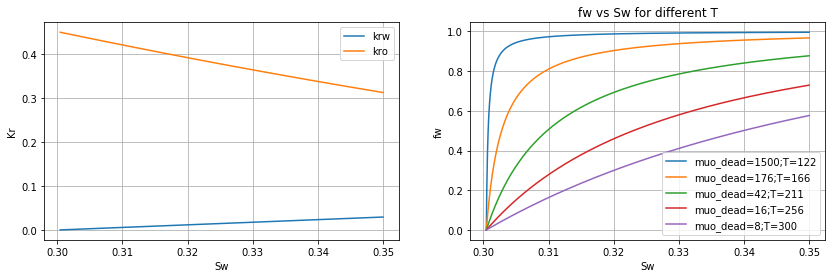

In [297]:
# plot relperm and fw of different T
fig = plt.figure(figsize=(14,4))
axs = [fig.add_subplot(121), fig.add_subplot(122)]
axs[0].plot(sw, krw, label='krw' )
axs[0].plot(sw, kro, label='kro')
axs[0].legend()
axs[0].set_xlabel('Sw')
axs[0].set_ylabel('Kr')
axs[0].grid()

# plot oil flow fraction
for T in T_arr:
    muo_dead = vis_2(a, b, T, T_ref)
    muo = muo_dead*0.92
    fw_mu = krw/muw/(kro/muo + krw/muw)
    axs[1].plot(sw, fw_mu, label=f'muo_dead={muo_dead:.0f};T={T:.0f}')
axs[1].legend()
axs[1].set_xlabel('Sw')
axs[1].set_ylabel('fw')
axs[1].set_title('fw vs Sw for different T')
axs[1].grid()

fw_list = [0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 0.98, 0.99]
mobile sw = [0.30109614 0.30128106 0.30155753 0.30201611 0.30292457 0.30558391
 0.31302258 0.32393621]
so_init = [0.69890386 0.69871894 0.69844247 0.69798389 0.69707543 0.69441609
 0.68697742 0.67606379]


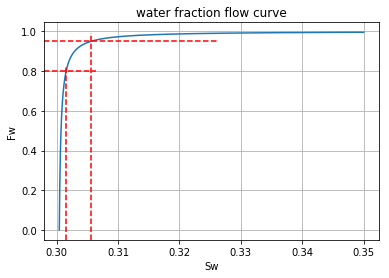

In [305]:
# plot fw of T = T_init
T = 122
muo_dead = vis_2(a, b, T, T_ref)
muo = muo_dead*0.92
fw_mu = krw/muw/(kro/muo + krw/muw)
ax = plt.subplot(111)
ax.plot(sw, fw_mu)
ax.set_xlabel('Sw')
ax.set_ylabel('Fw')
ax.axhline(y=0.8, color='r', linestyle='--', xmax=0.155)
ax.axvline(x=0.30155748, color='r', linestyle='--', ymax=0.8)
ax.axhline(y=0.95, color='r', linestyle='--', xmax=0.52)
ax.axvline(x=0.30558389, color='r', linestyle='--', ymax=0.95)
ax.grid()
ax.set_title('water fraction flow curve')

# interpolate to get sw_init
from scipy.interpolate import interp1d
sw_out = interp1d(fw_mu,sw)
#   focal = [                2     3     4    5      6      9]
fw_list = [0.7, 0.75, 0.8,  0.85, 0.9, 0.95, 0.98, 0.99]  #sw_init = 0.5
print(f'fw_list = {fw_list}')
print(f'mobile sw = {sw_out(fw_list)}')
print(f'so_init = {1 - sw_out(fw_list)}')

In [306]:
# focal 4
fw_list = [0.93872, 0.705907]
print(sw_out(fw_list)
sw_1 = [0.3063645488,0.306281644,0.3062702764,0.3061178326]
sw_88 = [0.3089813179, 0.3071650687, 0.3056260363, 0.3064367019]
sw_179 = [0.3016236631, 0.3015247372, 0.3016960063, 0.3018307185]
print(np.mean(sw_1), np.mean(sw_88), np.mean(sw_179))

0.30625857545 0.3070522812 0.301668781275


fo_list = [0.05, 0.1, 0.2]
mobile sw = [0.30558391 0.30292457 0.30155753]
so_init = [0.69441609 0.69707543 0.69844247]


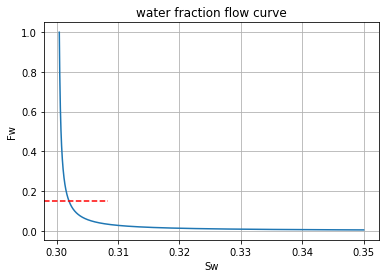

In [304]:
# plot fo of T = T_init
T = 122
muo_dead = vis_2(a, b, T, T_ref)
muo = muo_dead*0.92
ax = plt.subplot(111)
fo_mu = kro/muo/(kro/muo + krw/muw)
ax.plot(sw, fo_mu)
ax.set_xlabel('Sw')
ax.set_ylabel('Fw')
ax.axhline(y=0.15, color='r', linestyle='--', xmax=0.19)
ax.grid()
ax.set_title('water fraction flow curve')

sw_out = interp1d(fo_mu,sw)
#   focal = [4   3           2]
fo_list = [  0.05, 0.1, 0.2]
print(f'fo_list = {fo_list}')
print(f'mobile sw = {sw_out(fo_list)}')
print(f'so_init = {1 - sw_out(fo_list)}')